## Importation des données

In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')

In [3]:
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [4]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

In [5]:
targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [6]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [8]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [9]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.13)

In [10]:
targets_points[1]

array([29.], dtype=float32)

## MLP

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import time

In [17]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(35, 60)
        self.fc2 = nn.Linear(60,1)
#        self.fc3 = nn.Linear(100, 1)
        #self.fc1 = nn.Linear(35, 1)
    
    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [18]:
class hockey_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, index):
        d = self.data[index]
        if self.transforms is not None:
            d = self.transforms(d)
        return (d, self.labels[index])
    
    def __len__(self):
        return self.labels.shape[0]

In [63]:
def train(data, labels, nepochs):
    
#     trainset = hockey_dataset(
#         data[:train_size], labels[:train_size])
#     validset = hockey_dataset(
#         data[train_size:train_size+valid_size], labels[train_size:train_size+valid_size])
    
    trainset = hockey_dataset(
        data, labels)
    validset = hockey_dataset(
        data, labels)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle = True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=100, shuffle = False)
    
    network = Network().to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.SGD(network.parameters(), lr = 0.000002,
                            weight_decay=0.001, momentum = 0.5)
    
    loss_train, loss_valid = [],[]
    
    for epoch in range(nepochs):
        current_loss_train, current_loss_valid = 0,0
#         for param in network.parameters():
#             print('param: ',param)
#             print(param.shape)
#             #test_list.append(param)
        for data in trainloader:
            inputs, label = data
#             test_list = []
#             for param in network.parameters():
#                 test_list.append(param)
#            print('inputs: ',inputs.shape)
#             print('labels :',labels)
            #test_output = torch.mm(test_list[0],torch.transpose(inputs.to(device), 0, 1)) + test_list[1]
            optimizer.zero_grad()
            output = network(inputs.to(device))
            #print(output)
            #print('output :',output)
            loss = criterion(output, label.to(device))
            loss.backward()
            #print(loss.item())
            optimizer.step()
            current_loss_train += loss.item()
        loss_train.append(current_loss_train)
        
#         with torch.no_grad():
#             for data in validloader:
#                 inputs, label = data
#                 output = network(inputs.to(device))
#                 loss = criterion(output, label.to(device))
#                 current_loss_valid += loss.item()
        loss_valid.append(current_loss_valid)
        print('Epoch: {}'.format(epoch))
        print('Train loss: {0:.4f}'.format(loss_train[-1]))
        print('Valid loss: {0:.4f}'.format(loss_valid[-1]))
    print('Finished Training')
    
    return loss_train, loss_valid

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

Epoch: 0
Train loss: 202.1633
Valid loss: 0.0000
Epoch: 1
Train loss: 137.0712
Valid loss: 0.0000
Epoch: 2
Train loss: 133.5598
Valid loss: 0.0000
Epoch: 3
Train loss: 130.6702
Valid loss: 0.0000
Epoch: 4
Train loss: 127.1399
Valid loss: 0.0000
Epoch: 5
Train loss: 124.7878
Valid loss: 0.0000
Epoch: 6
Train loss: 121.5690
Valid loss: 0.0000
Epoch: 7
Train loss: 118.8903
Valid loss: 0.0000
Epoch: 8
Train loss: 116.0657
Valid loss: 0.0000
Epoch: 9
Train loss: 113.2276
Valid loss: 0.0000
Epoch: 10
Train loss: 110.7057
Valid loss: 0.0000
Epoch: 11
Train loss: 107.6484
Valid loss: 0.0000
Epoch: 12
Train loss: 106.5258
Valid loss: 0.0000
Epoch: 13
Train loss: 102.9911
Valid loss: 0.0000
Epoch: 14
Train loss: 100.5262
Valid loss: 0.0000
Epoch: 15
Train loss: 97.9546
Valid loss: 0.0000
Epoch: 16
Train loss: 95.6783
Valid loss: 0.0000
Epoch: 17
Train loss: 93.0605
Valid loss: 0.0000
Epoch: 18
Train loss: 90.9676
Valid loss: 0.0000
Epoch: 19
Train loss: 88.2428
Valid loss: 0.0000
Finished Traini

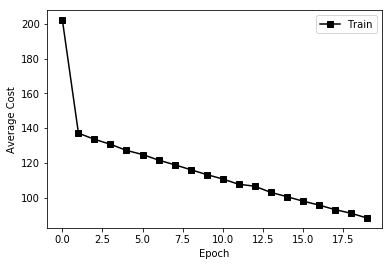

In [64]:
nepochs = 20
t1 = time.time()
loss_train, loss_valid = train(data, targets_goals, nepochs)
print("Temps d'entrainement : {}".format(time.time()-t1))
torch.cuda.empty_cache()

fig,ax = plt.subplots()
ax.plot(range(nepochs), loss_train, 'sk-', label='Train')
#ax.plot(range(nepochs), loss_valid, 'sr-', label='Valid')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Cost')
ax.legend()
plt.show()

In [55]:
(87.5-)**2

5112.25